In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:

#created variales for images size
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("C:/Users/Rakesh Dalvi/Downloads/MangoLeaf_data",
shuffle =True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size= BATCH_SIZE
)

Found 3107 files belonging to 7 classes.


In [5]:
class_names=dataset.class_names
class_names

['Bacterial_Canker',
 'Healthy  leaf',
 'Healthy leaf',
 'Sooty Mould  Leaf',
 'Sooty Mould leaf',
 'anthracnose  leaf',
 'anthracnose leaf']

In [6]:
len(dataset)

98

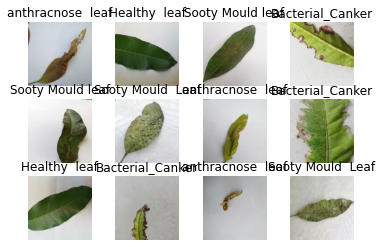

In [7]:
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        #to turn off the axis points
        plt.axis("off")
        
    

In [9]:
#SPLITTING DATASET
#80 for training
# 20 for validation
#10 for tetsing
train_size=0.8
len(dataset)*train_size


78.4

In [10]:
train_ds=dataset.take(54)
len(train_ds)

54

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

44

In [12]:
val_size=0.1
len(dataset)*val_size

9.8

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

38

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

78

In [20]:
len(val_ds)

9

In [21]:
len(test_ds)

11

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
#Data Augmentation
#Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)


In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
78/78 [==============================] - 910s 12s/step - loss: 1.3819 - accuracy: 0.3831 - val_loss: 1.2479 - val_accuracy: 0.4653
Epoch 2/25
78/78 [==============================] - 776s 10s/step - loss: 1.1439 - accuracy: 0.4779 - val_loss: 1.0730 - val_accuracy: 0.4792
Epoch 3/25
78/78 [==============================] - 825s 10s/step - loss: 1.0585 - accuracy: 0.5253 - val_loss: 1.0157 - val_accuracy: 0.5521
Epoch 4/25
78/78 [==============================] - 441s 6s/step - loss: 0.9852 - accuracy: 0.5565 - val_loss: 0.8424 - val_accuracy: 0.6424
Epoch 5/25
78/78 [==============================] - 314s 4s/step - loss: 0.9476 - accuracy: 0.5805 - val_loss: 0.7873 - val_accuracy: 0.7257
Epoch 6/25
78/78 [==============================] - 372s 5s/step - loss: 0.9068 - accuracy: 0.6279 - val_loss: 0.8762 - val_accuracy: 0.6667
Epoch 7/25
78/78 [==============================] - 321s 4s/step - loss: 0.8745 - accuracy: 0.6340 - val_loss: 0.7024 - val_accuracy: 0.7986
Epoch 8/25

In [36]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 9s 839ms/step - loss: 0.2469 - accuracy: 0.9006


In [37]:
scores

[0.2469225525856018, 0.9005681872367859]

In [38]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 78}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

25

In [42]:
history.history['loss'][:5] # show loss for first 5 epochs


[1.3819410800933838,
 1.143888235092163,
 1.0584731101989746,
 0.9852343797683716,
 0.947554886341095]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

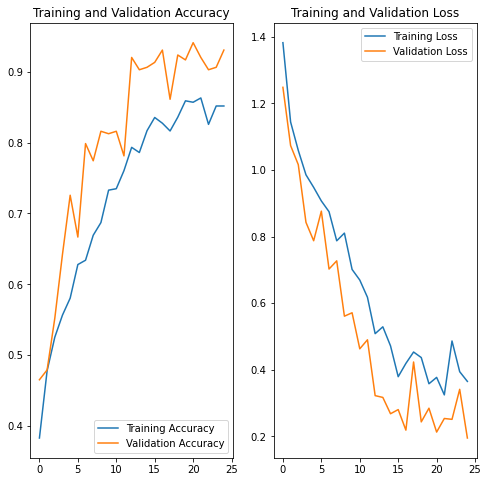

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Sooty Mould leaf
1/1 [==============================] - 2s 2s/step
predicted label: Sooty Mould leaf


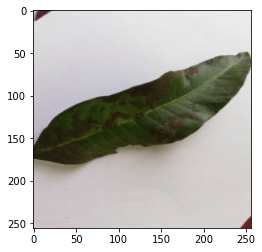

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 72ms/step


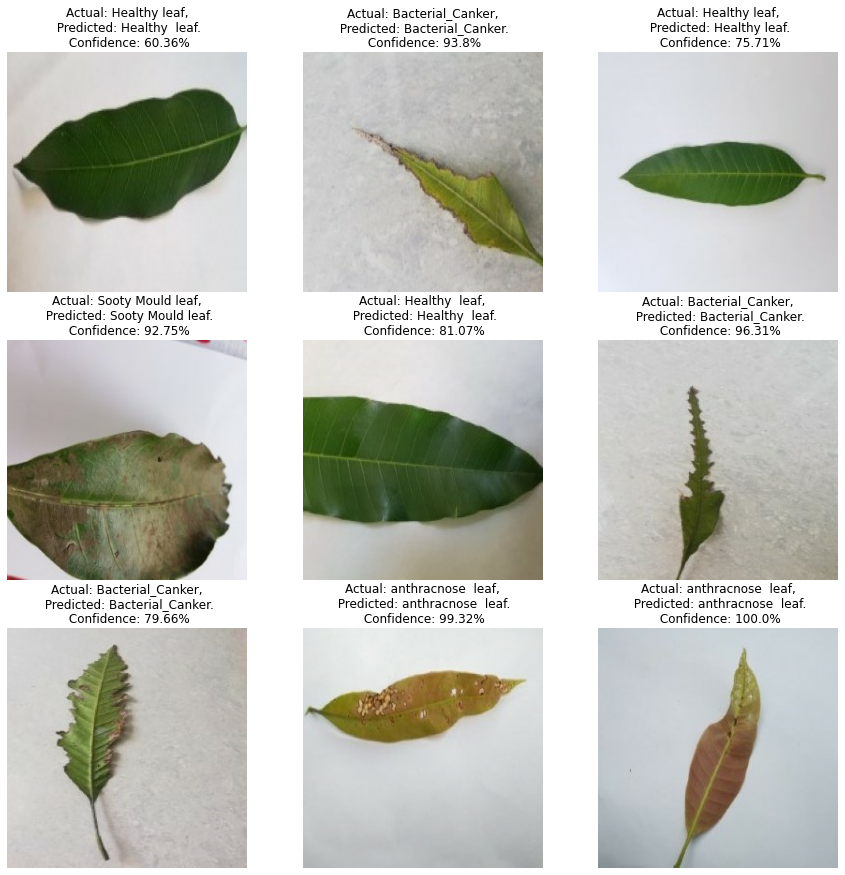

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [45]:
# import os
# model_version=max([int(i) for i in os.listdir("C:/Users/ASUS/Downloads/Major_Project1") + [0]])+1
# #model.save(f"../models/{model_version}")

import os
versions = []
for item in os.listdir("C:/Users/Rakesh Dalvi/Downloads/saved model") + [0]:
    try:
        version = int(item)
        versions.append(version)
    except ValueError:
        pass
model_version = max(versions) + 1

In [ ]:

model_version = max(versions) + 1
model.save(f"C:/Users/Rakesh Dalvi/Downloads/saved model/model_v{model_version}.h5")
